# Question 6
With reference to the InsideAirbnb data (i.e. using numbers, figures, maps, and descriptive statistics), what does an analysis of Hosts and the types of properties that they list suggest about the nature of Airbnb lettings in London? To do for final: Add descriptions to each map. 

In [81]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy import stats

In [82]:
##--Airbnb Data--##

airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)

airbnb.head(5)

,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,...,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry
0,1126718007114818432,https://www.airbnb.com/rooms/1126718007114818431,2024-06-14,Cozy house in Northolt,Located 1 minute away from a bus stop and 10 m...,380326752,Sadikshya,2020-12-15,NaN,False,...,48.0,3,365,269,0,NaN,NaN,NaN,NaN,POINT (511488.009 183013.814)
1,702589406864297984,https://www.airbnb.com/rooms/702589406864297985,2024-06-15,Up in the sky in London!,"One bedroom with double bed, desk and with th...",77760754,Lena,2016-06-14,"London, United Kingdom",True,...,42.0,1,365,146,83,2023-08-30,2024-06-13,4.94,8.56,POINT (536180.695 185752.726)
2,1122535727514526720,https://www.airbnb.com/rooms/1122535727514526769,2024-06-14,Luxury Stays in SE London (2bed),Welcome to Our Home has recently refurbished o...,322107481,"Nick And Sandy,",2019-12-29,NaN,False,...,150.0,6,365,162,0,NaN,NaN,NaN,NaN,POINT (541020.586 170091.026)
3,904867371314200192,https://www.airbnb.com/rooms/904867371314200140,2024-06-14,"Free Parking: Luxury, Comfy, Near Airport, Net...",Delight in elegance near Heathrow. Sink into t...,517837625,Suite,2023-06-02,"London, United Kingdom",True,...,104.0,2,1125,208,14,2023-06-08,2024-05-17,4.93,1.13,POINT (506216.561 179804.232)
4,809481748064671744,https://www.airbnb.com/rooms/809481748064671711,2024-06-15,4 min walk from the station 1 bedroom apartment,This indipendent apartment has a style. Well ...,30949469,Elisa,2015-04-10,"London, United Kingdom",False,...,82.0,1,95,65,5,2024-04-21,2024-05-26,5.00,2.68,POINT (536185.87 187333.241)


In [83]:
#London Ward Profiles 
##--London Ward Profiles--##

ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

#including only selected variables
ward_profiles = ward_profiles[['Ward name', 'New code','Average Public Transport Accessibility score - 2014','Median House Price (£) - 2014','Median Household income estimate (2012/13)','(ID2010) - Rank of average score (within London) - 2010','(ID2010) % of LSOAs in worst 50% nationally - 2010','Average GCSE capped point scores - 2014',
    '% BAME - 2011','Number of Household spaces - 2011']]

ward_profiles.head(2)

,Ward name,New code,Average Public Transport Accessibility score - 2014,Median House Price (£) - 2014,Median Household income estimate (2012/13),(ID2010) - Rank of average score (within London) - 2010,(ID2010) % of LSOAs in worst 50% nationally - 2010,Average GCSE capped point scores - 2014,% BAME - 2011,Number of Household spaces - 2011
0,City of London,E09000001,7.9,765000.0,63620.0,551.0,20.0,354.5,21.4,5530
1,Barking and Dagenham - Abbey,E05000026,6.0,173000.0,33920.0,166.0,85.7,317.7,71.9,4753


In [84]:
#filtering data 
from datetime import datetime, timedelta

# Filter min. nights
filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

## To determine recently active sites

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

In [60]:
##--Wards Geometry Data--##

wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE", "HECTARES", "geometry"]]
boroughs = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp").to_crs(epsg=27700)[["NAME", "GSS_CODE", "geometry"]]


inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]
inner_boroughs = boroughs[boroughs['NAME'].isin(inner_london_boroughs)]


Airbnb’s short-term listings are clustered in boroughs surrounding the City of London. 14.4% of listings occur in Westminster, followed by 8.1% in Kensington and Chelsea, then 7.5% in Camden. 



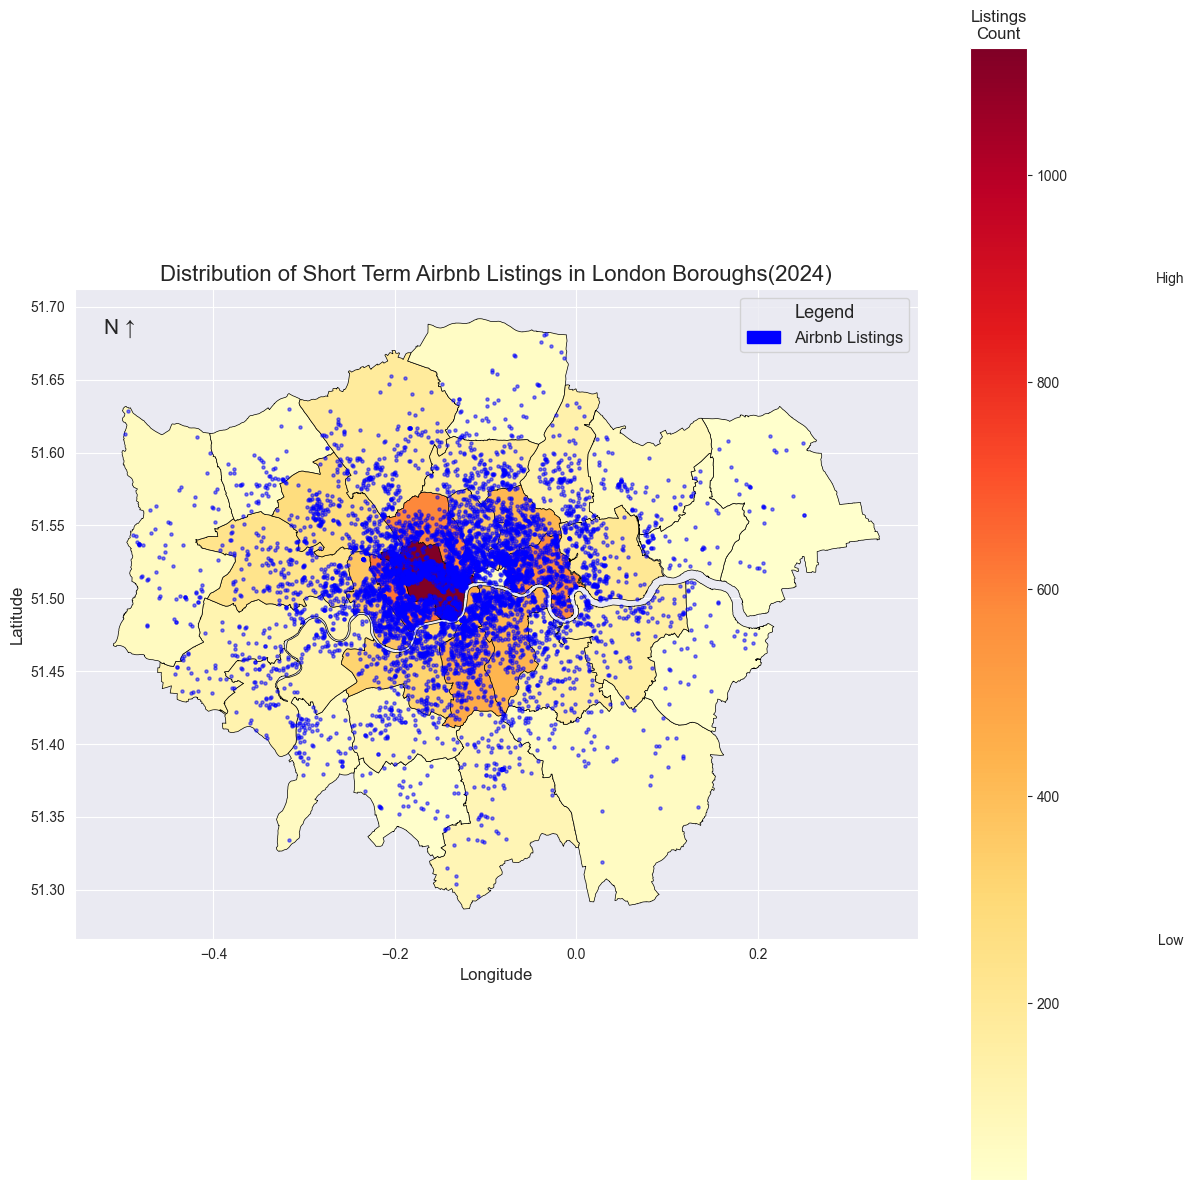

In [86]:
# Ensuring boroughs have a CRS set
if boroughs.crs is None:
    boroughs.set_crs(epsg=27700, inplace=True) 
boroughs = boroughs.to_crs(epsg=4326)  

# Ensuring Airbnb data is a GeoDataFrame and set CRS if missing
if filtered_airbnb.crs is None:
    filtered_airbnb = gpd.GeoDataFrame(
        filtered_airbnb,
        geometry=filtered_airbnb.geometry,
        crs="EPSG:27700"  
    )
filtered_airbnb = filtered_airbnb.to_crs(epsg=4326)  

# Perform spatial join to assign each Airbnb to a borough
airbnb_in_boroughs = gpd.sjoin(filtered_airbnb, boroughs, how="inner", predicate="within")

# Counting the number of Airbnb listings in each borough
borough_counts = airbnb_in_boroughs.groupby("NAME").size().reset_index(name="Airbnb_Counts")

# Merging the counts back with the boroughs GeoDataFrame
boroughs = boroughs.merge(borough_counts, left_on="NAME", right_on="NAME", how="left")

# Filling NaN values with 0 (in case there are boroughs with no Airbnb listings)
boroughs["Airbnb_Counts"] = boroughs["Airbnb_Counts"].fillna(0)

# Plotting the choropleth map with Airbnb points
fig, ax = plt.subplots(figsize=(12, 12))

# Plotting the boroughs and shade based on Airbnb counts
choropleth = boroughs.plot(
    column="Airbnb_Counts",
    cmap="YlOrRd",  # Bright red -> orange -> yellow
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Resizing and customizing the colourbar legend
colorbar = choropleth.get_figure().get_axes()[1]
colorbar.set_title("Listings\nCount", fontsize=12)
colorbar.text(1.3, 1.01, "High", fontsize=10, transform=ax.transAxes, ha="center")
colorbar.text(1.3, -0.01, "Low", fontsize=10, transform=ax.transAxes, ha="center")

# Plotting Airbnb points on top
filtered_airbnb.plot(
    ax=ax,
    color="blue",
    markersize=5,
    alpha=0.5,
    label="Airbnb Listings"
)

# Addding a north arrow to the top-left corner
north_arrow = AnchoredText("N ↑", loc="upper left", prop=dict(size=15), frameon=False, borderpad=1)
ax.add_artist(north_arrow)

# Customizing the legend and placeing it on the right
airbnb_patch = mpatches.Patch(color="blue", label="Airbnb Listings")
legend = ax.legend(handles=[airbnb_patch], title="Legend", fontsize=12, loc="upper right", title_fontsize=13)

# Adding title and labels
plt.title("Distribution of Short Term Airbnb Listings in London Boroughs(2024)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Final adjustments and showing the map
plt.tight_layout()
plt.show()


In [87]:
# Listing all Airbnb counts and calculating percentages
# Performing spatial join to assign each Airbnb to a borough
airbnb_in_boroughs = gpd.sjoin(filtered_airbnb, boroughs, how="inner", predicate="within")

# Count the number of Airbnb listings in each borough
borough_counts = airbnb_in_boroughs.groupby("NAME").size().reset_index(name="Airbnb_Counts")

# Fill NaN values with 0 in case of missing boroughs
borough_counts = borough_counts.fillna(0)

# Calculate the total number of Airbnb listings
total_listings = borough_counts["Airbnb_Counts"].sum()

# Calculate the percentage of listings in each borough
borough_counts["Percentage"] = (borough_counts["Airbnb_Counts"] / total_listings) * 100

# Sort the counts by the percentage of listings
borough_counts = borough_counts.sort_values(by="Percentage", ascending=False)

# Print the borough names with percentages
print("Boroughs with Airbnb Percentages:")
print(borough_counts[["NAME", "Airbnb_Counts", "Percentage"]])

# Save the result to a CSV file (optional)
borough_counts.to_csv("airbnb_percentage_by_borough.csv", index=False)



Boroughs with Airbnb Percentages:
                      NAME  Airbnb_Counts  Percentage
32             Westminster           1123   14.408519
19  Kensington and Chelsea            629    8.070310
5                   Camden            586    7.518604
29           Tower Hamlets            578    7.415961
21                 Lambeth            463    5.940467
27               Southwark            429    5.504234
11                 Hackney            421    5.401591
12  Hammersmith and Fulham            367    4.708750
18               Islington            348    4.464973
31              Wandsworth            320    4.105722
3                    Brent            279    3.579677
8                   Ealing            233    2.989479
24                  Newham            200    2.566076
1                   Barnet            182    2.335130
13                Haringey            171    2.193995
22                Lewisham            163    2.091352
10               Greenwich            155    1.9

# Calculating the Average Price of Airbnb Listings in London Boroughs


Average Price of Airbnb Listings per Borough:
                      NAME  Average_Price
32             Westminster          321.0
19  Kensington and Chelsea          284.0
6           City of London          233.0
5                   Camden          202.0
31              Wandsworth          179.0


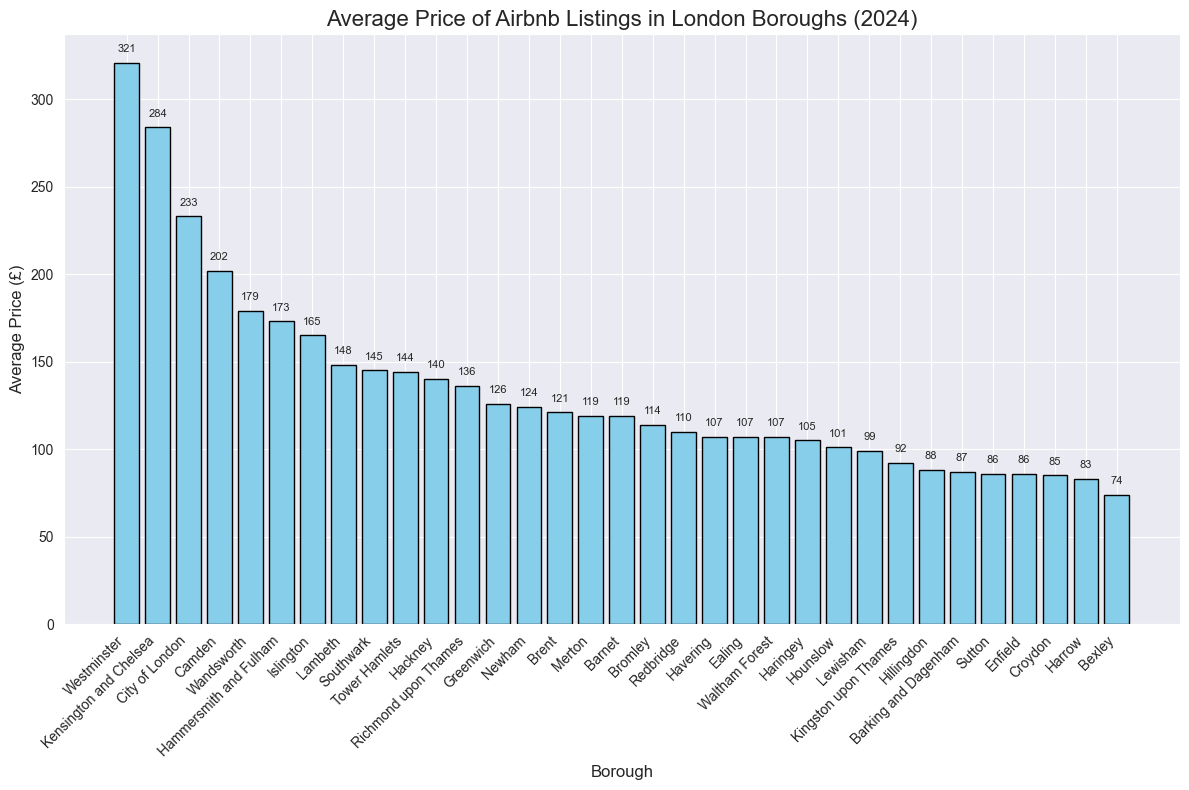

In [88]:
# Calculating the average price of Airbnb listings in each borough
borough_prices = airbnb_in_boroughs.groupby("NAME")["price"].mean().reset_index(name="Average_Price")

# Rounding the average price to whole numbers
borough_prices["Average_Price"] = borough_prices["Average_Price"].round(0)

# Sorting the boroughs by average price for a cleaner plot
borough_prices = borough_prices.sort_values(by="Average_Price", ascending=False)

# Debugging: Printing the first few rows of average prices
print("Average Price of Airbnb Listings per Borough:")
print(borough_prices.head())

# Plotting the average price as a bar graph
plt.figure(figsize=(12, 8))
plt.bar(borough_prices["NAME"], borough_prices["Average_Price"], color="skyblue", edgecolor="black")

# Adding titles and labels
plt.title("Average Price of Airbnb Listings in London Boroughs (2024)", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Average Price (£)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adding data labels on top of each bar
for i, value in enumerate(borough_prices["Average_Price"]):
    plt.text(i, value + 5, f"{int(value)}", ha="center", va="bottom", fontsize=8)

# Adjusting layout for better appearance
plt.tight_layout()

# Showing the output 
plt.show()


Westminster, Kensington and Chelsea, and the City of London exhibit the highest average prices, while Bexley and Harrow have the lowest, reflecting significant variation in short-term rental costs across the city.

# Properties Rented for over 90+ nights
A concern that Airbnb imposes in London is ‘commercialisation’. The Greater London Authority (GLA) states that “it creates a risk of residential properties being used as letting businesses without the required planning permission and protections for neighbours” (Cromarty, 2024, p.26). To avoid this issue, homeowners are required to obtain planning permission if they intend to use residential properties for short-term accommodation exceeding 90 nights.  
In the current 2024 analysis, we found that there is a total of 6254 listings available for over 90+ nights. Westminster has 15.7% of those listings, Kensington and Chelsea at 9%, and Tower Hamlets at 7.5%. 


In [96]:
# Ensuring boroughs have a CRS set
if boroughs.crs is None:
    boroughs.set_crs(epsg=27700, inplace=True)  
boroughs = boroughs.to_crs(epsg=4326)  

# Ensuring Airbnb data is a GeoDataFrame and set CRS if missing
if filtered_airbnb.crs is None:
    filtered_airbnb = gpd.GeoDataFrame(
        filtered_airbnb,
        geometry=filtered_airbnb.geometry,
        crs="EPSG:27700"  
    )
filtered_airbnb = filtered_airbnb.to_crs(epsg=4326)  

# Filtering listings for 90+ nights of availability
filtered_airbnb = filtered_airbnb[filtered_airbnb['maximum_nights'] >= 90]

# Performing a spatial join to assign each Airbnb to a borough
airbnb_in_boroughs = gpd.sjoin(filtered_airbnb, boroughs, how="inner", predicate="within")

# Counting the number of Airbnb listings in each borough
borough_counts = airbnb_in_boroughs.groupby("NAME").size().reset_index(name="Airbnb_Counts")

# Calculating the percentage of listings for each borough
total_listings = borough_counts["Airbnb_Counts"].sum()
borough_counts["Percentage"] = (borough_counts["Airbnb_Counts"] / total_listings) * 100

# Displaying results
print("Airbnb Listings Available for 90+ nights by Borough (With Percentage):")
print(borough_counts)

# Displaying the total number of listings
print(f"\nTotal Airbnb Listings Available for 90+ nights: {total_listings}")



Airbnb Listings Available for 90+ nights by Borough (With Percentage):
                      NAME  Airbnb_Counts  Percentage
0     Barking and Dagenham             31    0.495683
1                   Barnet            153    2.446434
2                   Bexley             26    0.415734
3                    Brent            205    3.277902
4                  Bromley             47    0.751519
5                   Camden            465    7.435241
6           City of London             53    0.847458
7                  Croydon             84    1.343140
8                   Ealing            184    2.942117
9                  Enfield             38    0.607611
10               Greenwich            131    2.094659
11                 Hackney            327    5.228654
12  Hammersmith and Fulham            303    4.844899
13                Haringey            137    2.190598
14                  Harrow             42    0.671570
15                Havering             26    0.415734
16         

Total Airbnb Listings Available for 90+ Nights: 6254

Room Types Available for 90+ Nights:
         Room Type  Count
0  Entire home/apt   4455
1     Private room   1774
2      Shared room     19
3       Hotel room      6


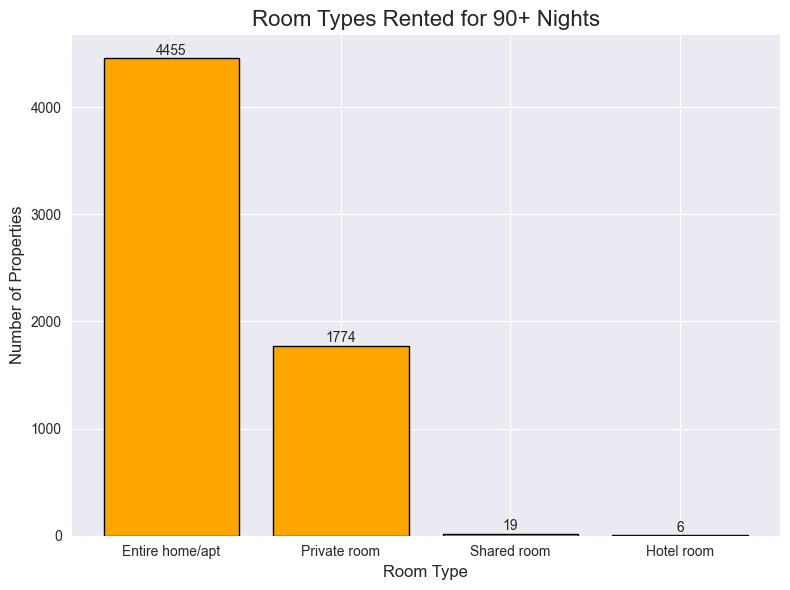

In [100]:
# Ensuring boroughs have a CRS set
if boroughs.crs is None:
    boroughs.set_crs(epsg=27700, inplace=True)  
boroughs = boroughs.to_crs(epsg=4326)  

# Ensuring Airbnb data is a GeoDataFrame and set CRS if missing
if filtered_airbnb.crs is None:
    filtered_airbnb = gpd.GeoDataFrame(
        filtered_airbnb,
        geometry=filtered_airbnb.geometry,
        crs="EPSG:27700"  
    )
filtered_airbnb = filtered_airbnb.to_crs(epsg=4326)  

# Filtering listings for 90+ nights of availability
filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

# Total number of listings
total_properties = len(filtered_airbnb)
print(f"Total Airbnb Listings Available for 90+ Nights: {total_properties}")

# Grouping by room type to count properties rented for 90+ nights
room_type_counts = filtered_airbnb["room_type"].value_counts().reset_index()
room_type_counts.columns = ["Room Type", "Count"]

# Printing the room type counts
print("\nRoom Types Available for 90+ Nights:")
print(room_type_counts)

# Plotting the room types as a bar graph
plt.figure(figsize=(8, 6))
plt.bar(room_type_counts["Room Type"], room_type_counts["Count"], color="orange", edgecolor="black")

# Adding titles and labels
plt.title("Room Types Rented for 90+ Nights", fontsize=16)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)

# Adding data labels on top of each bar
for i, value in enumerate(room_type_counts["Count"]):
    plt.text(i, value + 5, str(value), ha="center", va="bottom", fontsize=10)

# Displaying the graph
plt.tight_layout()
plt.show()


The most common ‘room types’ available for over 90+ nights are entire homes and apartments. 



# Hosts with Multiple Listings
GLA have discovered that hosts with multiple listings on Airbnb are more likely to be using the platform for commercial purposes (Cromarty, 2024, p.25). The total number of hosts with two or more listings is 6253 with the average number of listings per host being 7.06. The maximum number of listings is 1253 that belong to Sykes Holiday Cottages. This shows that the Airbnb market in London is commercialised and does not adhere to the GLA 90-night policy limit. 

In [80]:
# Filter hosts with total listings greater than 2
hosts_with_2plus_listings = airbnb[airbnb["host_listings_count"] >= 2]

# Group by host_name and aggregate total listings
hosts_summary = hosts_with_2plus_listings.groupby("host_name").agg(
    total_listings=("host_listings_count", "first")
).reset_index()

# Calculate required metrics
total_hosts = hosts_summary.shape[0]
average_listings = hosts_summary["total_listings"].mean()
max_listings = hosts_summary["total_listings"].max()
min_listings = hosts_summary["total_listings"].min()

# Find the host(s) with the most listings
host_with_max_listings = hosts_summary[hosts_summary["total_listings"] == max_listings]

# Print the results
print(f"Total number of hosts with more than 2 listings: {total_hosts}")
print(f"Average number of listings per host: {average_listings:.2f}")
print(f"Maximum number of listings: {max_listings}")
print(f"Minimum number of listings (2 or more): {min_listings}")

print("\nHost(s) with the most listings:")
print(host_with_max_listings)



Total number of hosts with more than 2 listings: 6253
Average number of listings per host: 7.06
Maximum number of listings: 1253
Minimum number of listings (2 or more): 2

Host(s) with the most listings:
                   host_name  total_listings
5518  Sykes Holiday Cottages            1253
